In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.ensemble import RandomForestRegressor
pio.renderers.default = 'notebook'

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

In [2]:
df = pd.read_csv('diabetes.csv') #read based on type 
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


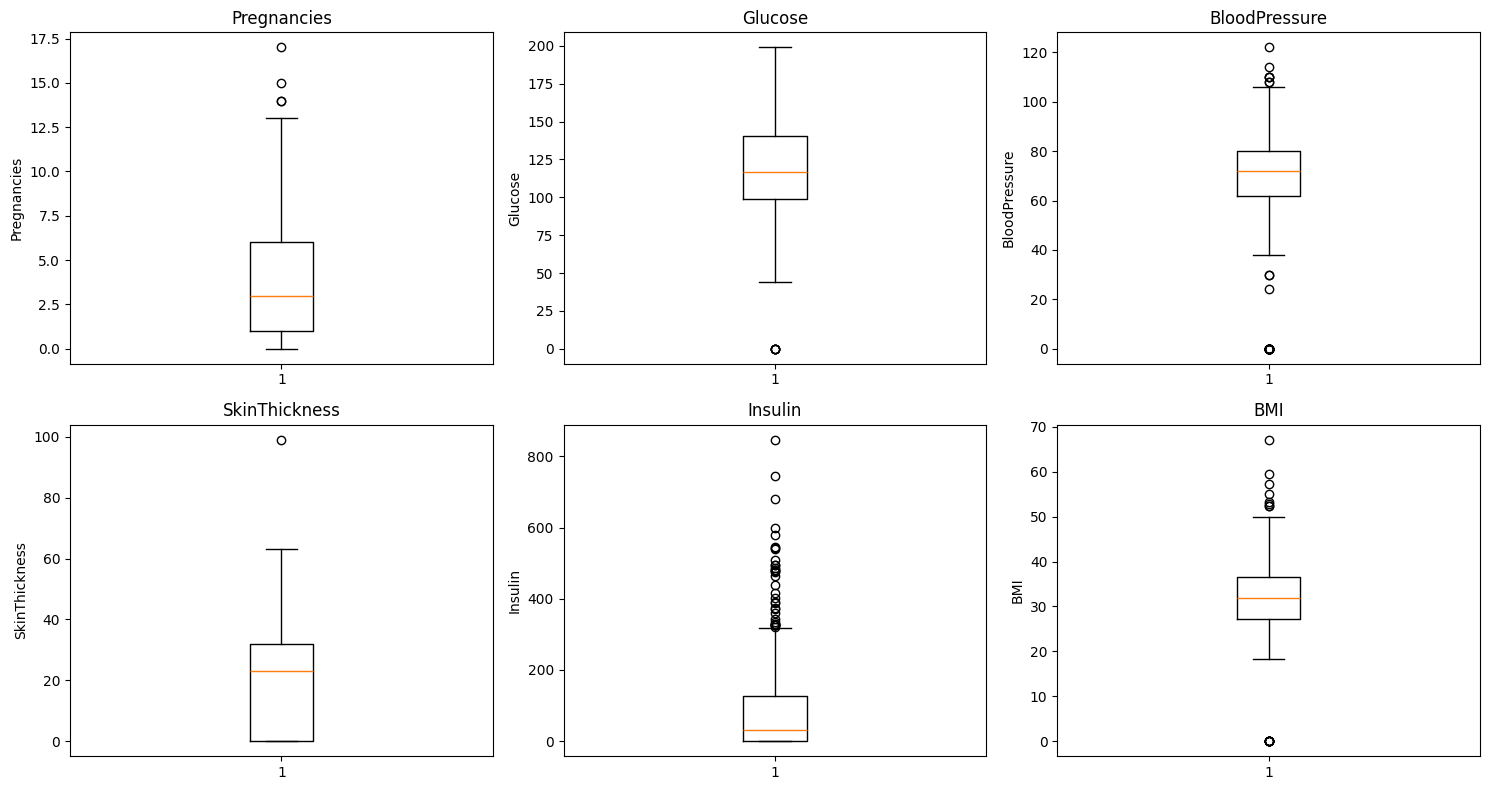

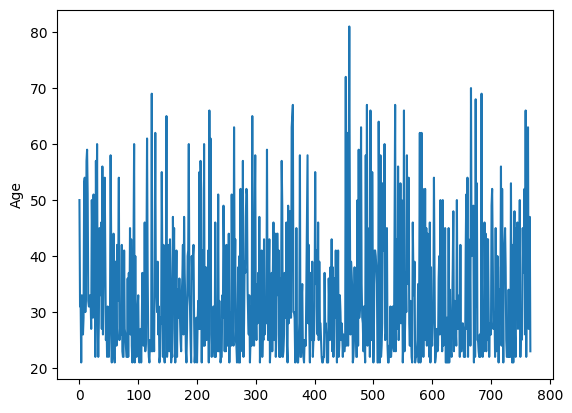

In [3]:
# Select only the continuous numeric columns you want to plot
cols_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))

for i, feature in enumerate(cols_to_plot):
    row = i // cols
    col = i % cols
    axes[row, col].boxplot(df[feature])
    axes[row, col].set_title(f"{feature}")
    axes[row, col].set_ylabel(feature)

# Hide any unused subplot (if fewer than rows*cols)
for j in range(len(cols_to_plot), rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()

plt.plot(df['Age'])
plt.ylabel("Age")
plt.show()

In [4]:
df.min()

Pregnancies                  0.000
Glucose                      0.000
BloodPressure                0.000
SkinThickness                0.000
Insulin                      0.000
BMI                          0.000
DiabetesPedigreeFunction     0.078
Age                         21.000
Outcome                      0.000
dtype: float64

# Data processing 
1: Pregnancies value can be zero, but the remaining values cannot. Therefore, remove any patient which has a zero value.  


In [5]:
# List of columns where 0 is considered invalid
col_names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Drop rows where any of these columns have a 0
df_with_dropped_zeros = df.copy()
for col in col_names:
    df_with_dropped_zeros = df_with_dropped_zeros[df_with_dropped_zeros[col] != 0]

# Pre-processing before AI
1: Split data 

2: Train Logistic regression. 

In [6]:
X_values_Names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
Y_values_Names = ['Outcome']



# Define X and y
X = df_with_dropped_zeros[X_values_Names]
y = df_with_dropped_zeros[Y_values_Names]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Fit the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train.values.ravel())  # .ravel() flattens y if it's a DataFrame

# 2. Predict on test set
y_pred = model.predict(X_test) #Have or not have? 

# 3. Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (diabetic) => Actual prob

# 4. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred), "Precission:", precision_score(y_test, y_pred))

feature_importance = pd.DataFrame({
    'Feature': X_values_Names,
    'Coefficient': model.coef_[0]
})

print(feature_importance)

Accuracy: 0.7341772151898734 Precission: 0.6666666666666666
         Feature  Coefficient
0        Glucose     0.036987
1  BloodPressure     0.005419
2  SkinThickness     0.024210
3        Insulin     0.001020
4            BMI     0.043692
5            Age     0.045691


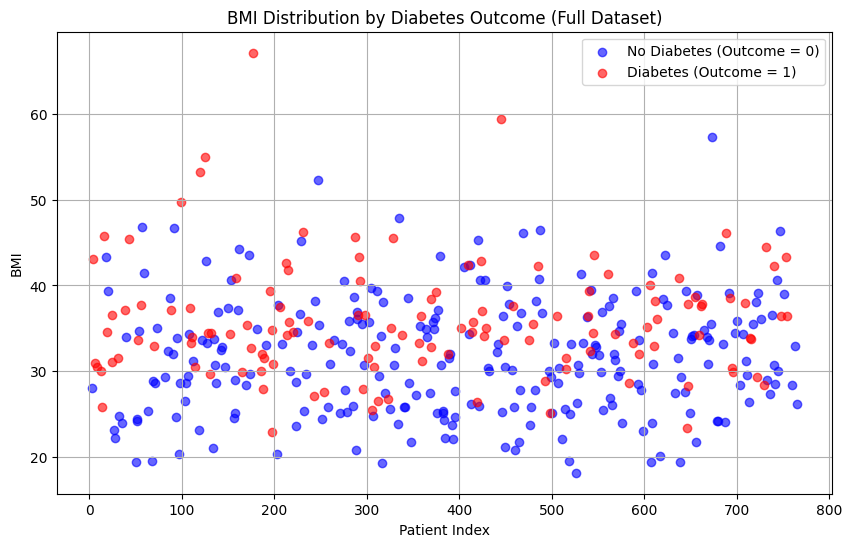

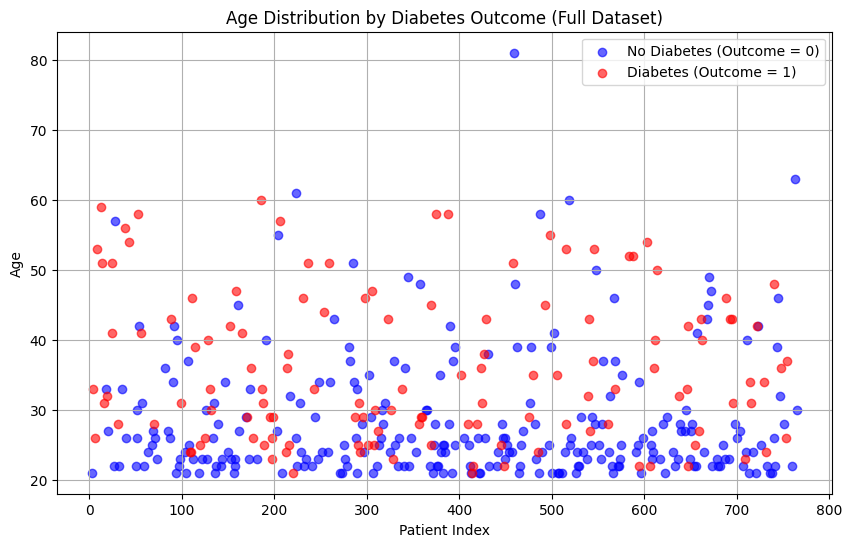

In [7]:
# Split full dataset into diabetic and non-diabetic groups
non_diabetic = df_with_dropped_zeros[df_with_dropped_zeros['Outcome'] == 0]
diabetic = df_with_dropped_zeros[df_with_dropped_zeros['Outcome'] == 1]

# Plot BMI for both groups
plt.figure(figsize=(10, 6))
plt.scatter(non_diabetic.index, non_diabetic['BMI'], color='blue', label='No Diabetes (Outcome = 0)', alpha=0.6)
plt.scatter(diabetic.index, diabetic['BMI'], color='red', label='Diabetes (Outcome = 1)', alpha=0.6)

plt.title('BMI Distribution by Diabetes Outcome (Full Dataset)')
plt.xlabel('Patient Index')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(non_diabetic.index, non_diabetic['Age'], color='blue', label='No Diabetes (Outcome = 0)', alpha=0.6)
plt.scatter(diabetic.index, diabetic['Age'], color='red', label='Diabetes (Outcome = 1)', alpha=0.6)

plt.title('Age Distribution by Diabetes Outcome (Full Dataset)')
plt.xlabel('Patient Index')
plt.ylabel('Age')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Combine X_test and y_prob into one DataFrame
prob_df = X_test.copy()
prob_df['Predicted_Probability'] = y_prob

# Define BMI bins
bmi_bins = [(10, 20), (20, 30), (30, 40), (40, prob_df['BMI'].max())]

# Loop through bins and calculate median probability and count
for lower, upper in bmi_bins:
    subset = prob_df[(prob_df['BMI'] >= lower) & (prob_df['BMI'] < upper)]
    median_prob = subset['Predicted_Probability'].median()
    count = len(subset)
    print(f"BMI {lower}–{upper}: Median Probability = {median_prob:.3f}, Patients = {count}")

BMI 10–20: Median Probability = 0.031, Patients = 1
BMI 20–30: Median Probability = 0.076, Patients = 30
BMI 30–40: Median Probability = 0.284, Patients = 37
BMI 40–55.0: Median Probability = 0.516, Patients = 10



The conclusion above seems to indicate that BMI and Age are good predictors of having diabetes. However, the method of removing rows which contains 0 seems to have removed almost 50% of the total patients. The new method aims to estimate the incorrect data (Glucose can't be zero for instance). 


Accuracy: 0.7532467532467533 Precission: 0.660377358490566
         Feature  Coefficient
0        Glucose     0.037903
1  BloodPressure    -0.013376
2  SkinThickness     0.006388
3        Insulin    -0.001199
4            BMI     0.104904
5            Age     0.046429
BMI 10–20: Median Probability = 0.035, Patients = 4
BMI 20–30: Median Probability = 0.110, Patients = 52
BMI 30–40: Median Probability = 0.372, Patients = 77
BMI 40–53.2: Median Probability = 0.650, Patients = 20


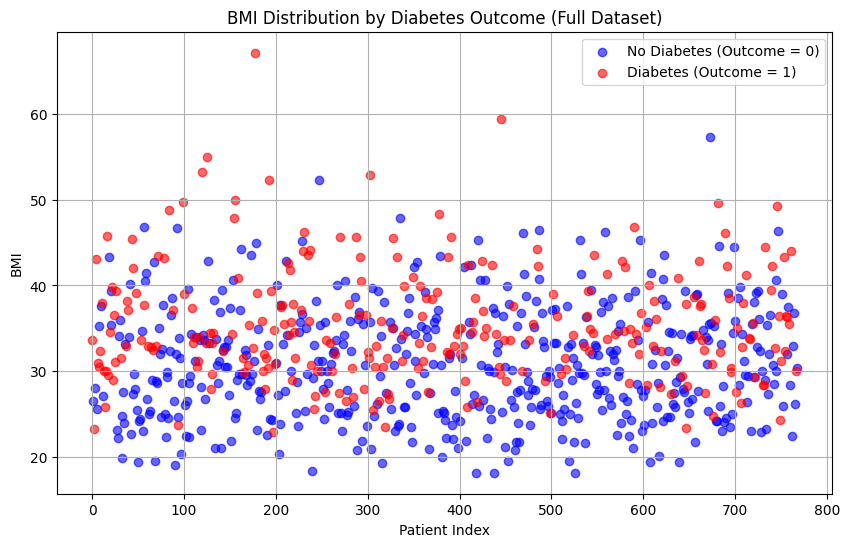

In [14]:
# Step 1: Create a copy of the original DataFrame
df_with_impute_with_model = df.copy()

# Step 2: Create a clean version with no zeros in suspect columns
df_with_dropped_zeros = df[(df[col_names] != 0).all(axis=1)]

# Step 3: Loop through each suspect column and impute zeros
for col in col_names:
    # Ensure column is float to avoid dtype warning
    df_with_impute_with_model[col] = df_with_impute_with_model[col].astype(float)

    # Prepare training data to predict 'col'
    X_train = df_with_dropped_zeros.drop(columns=[col])
    y_train = df_with_dropped_zeros[col]

    # Train model (Random Forest works well for nonlinear patterns)
    fixer = RandomForestRegressor()
    fixer.fit(X_train, y_train)

    # Identify rows in original data where 'col' is zero
    mask = df_with_impute_with_model[col] == 0
    X_missing = df_with_impute_with_model.loc[mask].drop(columns=[col])

    # Predict missing values
    predicted_values = fixer.predict(X_missing)

    # Replace zeros with predicted values
    df_with_impute_with_model.loc[mask, col] = predicted_values

# Define X and y
X = df_with_impute_with_model[X_values_Names]
y = df_with_impute_with_model[Y_values_Names]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Fit the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train.values.ravel())  # .ravel() flattens y if it's a DataFrame

# 2. Predict on test set
y_pred = model.predict(X_test) #Have or not have? 

# 3. Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (diabetic) => Actual prob

# 4. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred), "Precission:", precision_score(y_test, y_pred))

feature_importance = pd.DataFrame({
    'Feature': X_values_Names,
    'Coefficient': model.coef_[0]
})

print(feature_importance)

# Combine X_test and y_prob into one DataFrame
prob_df = X_test.copy()
prob_df['Predicted_Probability'] = y_prob

# Define BMI bins
bmi_bins = [(10, 20), (20, 30), (30, 40), (40, prob_df['BMI'].max())]

# Loop through bins and calculate median probability and count
for lower, upper in bmi_bins:
    subset = prob_df[(prob_df['BMI'] >= lower) & (prob_df['BMI'] < upper)]
    median_prob = subset['Predicted_Probability'].median()
    count = len(subset)
    print(f"BMI {lower}–{upper}: Median Probability = {median_prob:.3f}, Patients = {count}")

# Split full dataset into diabetic and non-diabetic groups
non_diabetic = df_with_impute_with_model[df_with_impute_with_model['Outcome'] == 0]
diabetic = df_with_impute_with_model[df_with_impute_with_model['Outcome'] == 1]

# Plot BMI for both groups
plt.figure(figsize=(10, 6))
plt.scatter(non_diabetic.index, non_diabetic['BMI'], color='blue', label='No Diabetes (Outcome = 0)', alpha=0.6)
plt.scatter(diabetic.index, diabetic['BMI'], color='red', label='Diabetes (Outcome = 1)', alpha=0.6)

plt.title('BMI Distribution by Diabetes Outcome (Full Dataset)')
plt.xlabel('Patient Index')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()

BMI plays a significant role in diabetes it seems, having a "normal" BMI up to starting to become obese seems to give a low risk of developing diabetes. However, a BMI of > 30 seems to triple the probability of developing it (medium to high risk) and a BMI of > 40 seems to 6x the probability. This conforms to research which suggests a strong link between BMI and developing diabetes. 